(128, 1, 1)
(1, 1)
Ndoms:  124
2.0 20 10
0
c: 0, x: 14.97, y: 10.11, z: -13.5, dima: 0.1906, poisson: 0.2
c: 100, x: 4.581, y: 0.149, z: -8.29, dima: 0.2859, poisson: 0.3
c: 200, x: -3.41, y: 7.493, z: 13.10, dima: 0.1906, poisson: 0.2
c: 300, x: 6.038, y: 7.164, z: -7.29, dima: 0.1906, poisson: 0.2
c: 400, x: 8.434, y: -10.8, z: 5.490, dima: 0.3812, poisson: 0.4
c: 500, x: -8.68, y: -11.9, z: 8.218, dima: 4.7655, poisson: 5.0
c: 600, x: 3.107, y: -11.8, z: -2.00, dima: 0.6671, poisson: 0.7
c: 700, x: 4.010, y: -4.82, z: -8.24, dima: 0.0953, poisson: 0.1
c: 800, x: 6.072, y: 13.84, z: -0.88, dima: -0.0, poisson: -0.0
c: 900, x: -8.23, y: -14.4, z: 9.520, dima: 0.0953, poisson: 0.1
c: 1000, x: -2.40, y: 6.561, z: 7.687, dima: -0.0, poisson: -0.0
c: 1100, x: 14.77, y: 7.811, z: -2.10, dima: -0.0, poisson: -0.0
c: 1200, x: -1.23, y: -14.4, z: -14.6, dima: -0.0, poisson: -0.0
c: 1300, x: -9.30, y: 10.62, z: 5.049, dima: 0.2859, poisson: 0.3000
c: 1400, x: -5.56, y: -13.7, z: 0.489, dima: 0

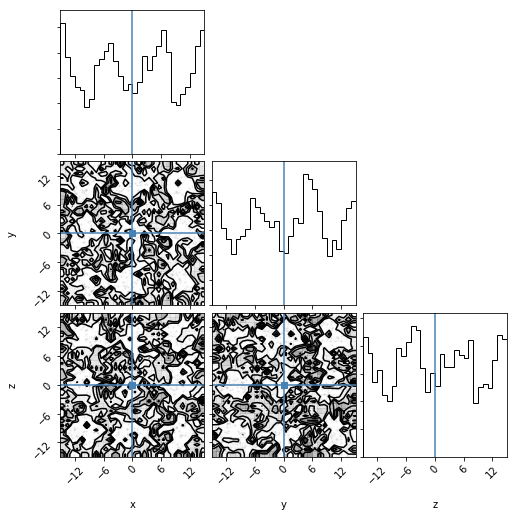

In [5]:
import numpy as np
import pycuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
from pycuda import gpuarray
import pycuda.driver as cuda
from pycuda import characterize
import matplotlib.pyplot as plt
import time

np.set_printoptions(suppress=True)

code = """	
#include <iostream>
#include <time.h>
#include "float.h"
#include <math.h>

#include <curand_kernel.h>
#include "stdio.h"

#include "vec3.h"
#include "dom_RT.h"

const int nstates = %(NGENERATORS)s;
const int ndoms = %(NDOMS)s;
__device__ curandStatePhilox4_32_10_t* rand_states[nstates];
__device__ vec3* pInit;
//__device__ vec3* positions[nstates];
// __device__ float *times[nstates];
__device__ dom *d_list[ndoms];
// __device__ int *hits[ndoms];

extern "C" {
    __global__ void initkernel(int seed, float xstart, float ystart, float zstart)
    {
        int tidx = threadIdx.x + blockIdx.x * blockDim.x;

        if (tidx <= nstates) {
            curandStatePhilox4_32_10_t* s = new curandStatePhilox4_32_10_t;
            if (s != 0) {
                curand_init(seed, tidx, 0, s);
            }

            rand_states[tidx] = s;
            //positions[tidx] = new vec3(xstart, ystart, zstart);
            // *times[tidx] = -1.0f;
        }

        if (tidx == 0) {
            pInit = new vec3(xstart, ystart, zstart);
        }
    }


    __global__ void updatekernel(int seed, float xstart, float ystart, float zstart)
    {
        int tidx = threadIdx.x + blockIdx.x * blockDim.x;

        if (tidx <= nstates) {
            curandStatePhilox4_32_10_t *s = rand_states[tidx];
            if (s != 0) {
                curand_init(seed, tidx, 0, s);
            }

            rand_states[tidx] = s;
            //*positions[tidx] = vec3(xstart, ystart, zstart);
            // *times[tidx] = -1.0f;
        }

        if (tidx == 0) {
            *pInit = vec3(xstart, ystart, zstart);
        }
    }


__global__
void create_doms(float radius, int d, int dN){
    if (threadIdx.x == 0 && blockIdx.x == 0) {
        printf("CreateDOMs ");
        //int d = 10;
        //int dN = 10;
        //float radius = 5.0f;
        printf("d: %(PRINT_I)s ", d);
        printf(", dN %(PRINT_I)s \\n", dN);
        int c = 0;
        for (int i=-d; i<=d; i += dN) {
            // printf(", i: %(PRINT_I)s ", i);
            for (int j=-d; j<=d; j += dN) {
                for (int k=-d; k<=d; k += dN) {
                    if (i != 0 || j != 0 || k != 0) {
                        // printf("%(PRINT_I)s ", c);
                        d_list[c++] = new dom(vec3( i,  j,  k), radius);
                        // *hits[c++] = 0;
                    }
                }
            }
        }

    }
}

}

#define checkCudaErrors(val) check_cuda( (val), #val, __FILE__, __LINE__ )
void check_cuda(cudaError_t result, char const *const func, const char *const file, int const line) {
    if (result) {
        // Make sure we call CUDA Device Reset before exiting
        cudaDeviceReset();
        exit(99);
    }
}


#define RNG (curand_uniform(&local_rand_state))

__device__
vec3 random_direction_3d(curandStatePhilox4_32_10_t *local_rand_state) {
    float dir_theta = curand_uniform(local_rand_state)*2.0f*M_PI;
    float vz = 2.0f*curand_uniform(local_rand_state)-1.0f;
    float vx = sqrtf(1.0f-powf(vz,2))*cosf(dir_theta);
    float vy = sqrtf(1.0f-powf(vz,2))*sinf(dir_theta);            
    return vec3(vx, vy, vz);
}

__device__
vec3 random_direction_2d(curandStatePhilox4_32_10_t *local_rand_state) {
    float dir_theta = curand_uniform(local_rand_state)*2*M_PI;
    float vx = cosf(dir_theta);
    float vy = sinf(dir_theta);            
    return vec3(vx, vy, 0);
}


__device__
float sample_geometric(float p, curandStatePhilox4_32_10_t *local_rand_state) {
    float ranNum = curand_uniform(local_rand_state);
    return -logf(ranNum)*p;
    //return ceilf(logf(1.0f-ranNum)/logf(1.0f-p));
}


extern "C" {
    __global__
    void simulate(int *hits, float *times) {
        int ind = threadIdx.x + blockIdx.x * blockDim.x;
        if (ind >= nstates) return;
        // printf("test1-%(PRINT_I)s ", ind);
        curandStatePhilox4_32_10_t local_rand_state = *rand_states[ind];
        vec3 dir = random_direction_3d(&local_rand_state);

        vec3 pHit;
        ray r(pInit[0], dir);
        vec3 Ppos = pInit[0];

        dom testdom(vec3( 0,  10,  30), 10);

        //float pa = 0.01f;
        //float ps = 0.01f;

        float pa = 1.0f;
        float ps = 100.0f;

        float pDist = sample_geometric(pa, &local_rand_state);

        float scatter = sample_geometric(ps, &local_rand_state);
        float t = 0;
        float tHit;
        // printf("test2-%(PRINT_I)s ", ind);
        // printf("%(PRINT_F)s %(PRINT_F)s %(PRINT_F)s ", (*positions[0]).x(), (*positions[0]).y(), (*positions[0]).z());
        // printf("radius-%(PRINT_F)s ", (*d_list[0]).radius );
        // printf("test3-%(PRINT_I)s ", ind);
        while (scatter < pDist) {
            // printf("ind-%(PRINT_I)s ", ind);
            for (int k=0; k<ndoms; k++){
                if ((*d_list[k]).hit(r, 0, scatter, &pHit, &tHit)) {
                    //hits[k] += 1;
                    atomicAdd(&hits[k], 1);
                    //*positions[ind] = pHit;
                    times[ind] = t + tHit;
                    // printf("Thread: %(PRINT_I)s, PhotonHit: %(PRINT_I)s \\n", ind, k);
                    // putchar(CR);
                    return;
                }
            }
            t += scatter;
            Ppos += r.direction()*scatter;
            pDist -= scatter;
            r = ray(Ppos, random_direction_3d(&local_rand_state));
            scatter = sample_geometric(ps, &local_rand_state);
        }


        for (int k=0; k<ndoms; k++){
            if ((*d_list[k]).hit(r, 0, pDist, &pHit, &tHit)) {
                //hits[k] += 1;
                atomicAdd(&hits[k], 1);
                //*positions[ind] = pHit;
                times[ind] = t + tHit;
                // printf("Thread: %(PRINT_I)s, PhotonHit: %(PRINT_I)s \\n", ind, k);
                return;
            }
        }

    }

}

"""

def LLH_dima(x, mu, os, deltamu=1e-1, vectorCalc=True) :
    from scipy.special import loggamma as lgamma
    x = x.copy()
    mu = mu.copy()
    '''
    Calculate dima LLH
    '''
    llh = 0
    if vectorCalc:
        mu_dima = (os*mu+x)/(os+1)
        mask_mu = mu != 0
        mask_x = x != 0
        llh += np.sum(os*mu[mask_mu]*np.log(mu_dima[mask_mu]/mu[mask_mu]))
        llh += np.sum(x[mask_x]*np.log(mu_dima[mask_x]/x[mask_x]))
        #llh += np.sum(x[~mask_mu] * np.log(deltamu) - mu[~mask_mu] - lgamma(x[~mask_mu] + 1))
    else:
        for i in range(len(x)):
            mu_dima = (os*mu[i]+x[i])/(os+1)
            if mu[i] != 0:
                llh += os*mu[i]*np.log(mu_dima/mu[i])

            if x[i] != 0:
                llh += x[i]*np.log(mu_dima/x[i])

    return -llh


def poisson_llh(x, mu, deltamu=1e-1, vectorCalc=True):
    from scipy.special import loggamma as lgamma
    llh = 0
    if vectorCalc:
        mask_mu = mu != 0
        llh += np.sum(x[mask_mu]*np.log(mu[mask_mu]) - mu[mask_mu] - lgamma(x[mask_mu] + 1))
        llh += np.sum(x[~mask_mu] * np.log(deltamu) - mu[~mask_mu] - lgamma(x[~mask_mu] + 1))
    else:
        for i in range(len(x)):
            if mu[i] > 0:
                llh += x[i] * np.log(mu[i]) - mu[i] - lgamma(x[i] + 1)
            else:
                llh += x[i] * np.log(deltamu) - mu[i] - lgamma(x[i] + 1)
    return -llh


def get_positions(x, y, z):
    return np.float32(x), np.float32(y), np.float32(z)

def evaluate(obs, x, y, z, oversampling, verbose=False):
    t1 = time.time()
    xstart, ystart, zstart = get_positions(x, y, z)
    hypos = []
    for i in range(oversampling):
        seed = np.random.randint(1, 12345, dtype=np.uint32)
        # seed = np.uint32(1337)
        datahits = np.zeros(Ndoms, dtype=np.int32)
        datatimes = np.zeros(Nphotons, dtype=np.float32)

        update_kernel(seed, xstart, ystart, zstart, block=bdim, grid=gdim)
        simulate(cuda.InOut(datahits), cuda.InOut(datatimes), block=bdim, grid=gdim)
        hypos.append(datahits)

    h = np.array(hypos).mean(axis=0)

    dima = LLH_dima(obs, h, oversampling, deltamu=1e-5)
    poisson = poisson_llh(obs, h, deltamu=1e-5)

    if verbose:
        print "Eval Time: ", time.time() - t1
    return dima, poisson

def make_grid():
    oversampling = 100
    N = 11
    xmin = -20
    xmax = 20
    xs = np.linspace(xmin, xmax, N)

    ymin = -20
    ymax = 20
    ys = np.linspace(ymin, ymax, N)

    print xs, ys

    Gx = np.zeros((xs.shape[0], ys.shape[0]))
    Gy = np.zeros((xs.shape[0], ys.shape[0]))

    Gdima = np.zeros((xs.shape[0], ys.shape[0]))
    Gpoisson = np.zeros((xs.shape[0], ys.shape[0]))

    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            dima, poisson = evaluate(obs, x, y, 0, oversampling)
            Gdima[i, j] = dima
            Gpoisson[i, j] = poisson
            Gx[i, j] = x
            Gy[i, j] = y

    t4 = time.time()

    np.savetxt("data/Gdima.txt", Gdima)
    np.savetxt("data/Gpoisson.txt", Gpoisson)
    np.savetxt("data/Gx.txt", Gx)
    np.savetxt("data/Gy.txt", Gy)


seed = np.uint32(666)
Nphotons = 100
Nthreads =128 #64

bdim = (Nthreads,1,1)
gdim =(Nphotons//Nthreads+1,1)

print bdim
print gdim


d = np.uint32(20)
dN = np.uint32(10)
radius = np.float32(2)
Ndoms = np.uint32(pow((d/dN)*2+1, 3) - 1)

print "Ndoms: ", Ndoms
print radius, d, dN


datahits = np.zeros(Ndoms, dtype=np.int32)
datatimes = np.zeros(Nphotons, dtype=np.float32)

mod = pycuda.compiler.SourceModule(code % { "NGENERATORS" : Nphotons, "NDOMS" : Ndoms , "PRINT_I" : "%i", "PRINT_F" : "%f" }, include_dirs=['/home/thomas/Documents/master_thesis/icecube_master_thesis/cuda'], no_extern_c=True)

init_rng = mod.get_function('initkernel')
update_kernel = mod.get_function("updatekernel")
init_doms = mod.get_function('create_doms')
simulate = mod.get_function('simulate')

xstart, ystart, zstart = get_positions(0, 0, 0)


init_rng(seed, xstart, ystart, zstart, block=bdim, grid=gdim)
init_doms(radius, d, dN, block=(1,1,1), grid=(1,1))

simulate(cuda.InOut(datahits),cuda.InOut(datatimes), block=bdim, grid=gdim)
obs = datahits

print obs.sum()

oversampling = 10

# print evaluate(obs, xstart, ystart, zstart, oversampling, verbose=True)

# x, y, z = get_positions(3.526,  5.369,  11.69)
# print evaluate(obs, x, y, z, oversampling, verbose=True)

import nestle

def prior_transform(theta):
    return 30 * theta - 15

global c
c = 0
steps = []
def f(args):
    global c
    x, y, z = args
    dima, poisson = evaluate(obs, x, y, z, oversampling)
    steps.append([x, y, z, dima, poisson])
    if c % 100 == 0:
        print "c: %s, x: %.5s, y: %.5s, z: %.5s, dima: %.6s, poisson: %.6s" % (c, x, y, z, dima, poisson)
    c+=1
    return -dima


# Run nested sampling
res = nestle.sample(f, prior_transform, 3, method='multi',
                    npoints=1000, maxcall=10000)
print(res.summary())

# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)

print("x = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("y = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
print("z = {0:5.2f} +/- {1:5.2f}".format(p[2], np.sqrt(cov[2, 2])))
#%%
import corner
fig = corner.corner(res.samples, weights=res.weights, labels=['x', 'y', "z"],
                    range=[0.9999999, 0.9999999, 0.9999999], truths=np.zeros(3), bins=30)

plt.show()



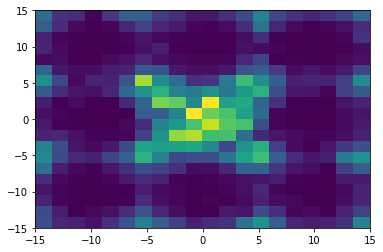

In [15]:
samples = res.samples
weights = res.weights

hist = plt.hist2d(samples[:,0 ], samples[:,1], weights=weights, bins=20)


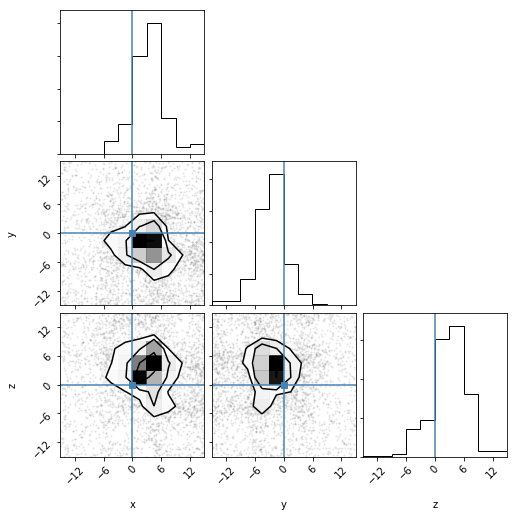

In [2]:
import corner

# fig = plt.figure(figsize=(12,8))

corner.corner(res.samples, weights=res.weights, labels=['x', 'y', "z"],
                    range=[0.99999999, 0.99999999, 0.99999999], truths=np.zeros(3), bins=10)

plt.show()